## 将GIF的第二张PNG抽出,其中一定包含四个数字

In [1]:
import os
from matplotlib import cm
from os import listdir
from mpl_toolkits.mplot3d import Axes3D
import struct
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image,ImageSequence
from collections import Counter
%matplotlib inline

def GIF_toPNG(path,savepath):
    #print("GIF/%d.gif"%(i+1))
    img = Image.open(path)
    select = 0
    for frame in ImageSequence.Iterator(img):
        select+=1
        if(select==2):frame.save(savepath)
    code_img = Image.open(savepath)
    code_size = code_img.size
    h = code_size[0]
    w = code_size[1]
    # print("GIF_PNG/%d.PNG"%(i+1))
    print("RAW GIF:%s\n保存 PNG:%s"%(path,savepath))
files = os.listdir("GIF")
for file in files:
    path = "GIF/"+str(file)
    savepath = "GIF_PNG/"+str(file)+".png"
    GIF_toPNG(path,savepath)
#GIF_toPNG(path)

RAW GIF:GIF/4.gif
保存 PNG:GIF_PNG/4.gif.png
RAW GIF:GIF/5.gif
保存 PNG:GIF_PNG/5.gif.png
RAW GIF:GIF/7.gif
保存 PNG:GIF_PNG/7.gif.png
RAW GIF:GIF/6.gif
保存 PNG:GIF_PNG/6.gif.png
RAW GIF:GIF/2.gif
保存 PNG:GIF_PNG/2.gif.png
RAW GIF:GIF/3.gif
保存 PNG:GIF_PNG/3.gif.png
RAW GIF:GIF/1.gif
保存 PNG:GIF_PNG/1.gif.png
RAW GIF:GIF/8.gif
保存 PNG:GIF_PNG/8.gif.png
RAW GIF:GIF/9.gif
保存 PNG:GIF_PNG/9.gif.png
RAW GIF:GIF/10.gif
保存 PNG:GIF_PNG/10.gif.png


## 切分PNG为4个单独数字的PNG
## 并保存到GIF_SPLIT文件夹下

In [2]:
def GIF_SPLIT(PATH,SAVEPATH):
    png_path = (PATH)
    code_img = Image.open(png_path)
    for i in range(4):
        ## 切隔成4张数字
        left = 21*i
        low = 19
        right = 21*(i+1)
        up = 40
        split = (left,low,right,up)
        img_save = code_img.crop(split)
        plt.imshow(img_save)
        plt.show()
        # img_save.save("GIF/%d.png"%i)
        img_array = np.array(img_save)


        ## 统计噪声
        ## Counter dict sorted
        result = Counter({})
        noise = []
        for j in img_array:
            result+=Counter(j)
        result = dict(result)
        #print(result)
        s = sorted(result.values(),reverse = True)
        img_array[img_array==s[0]]=0
        #print(i)

        ## 将噪声和背景全部置0，其他的全部置为1
        for k,v in result.items():
            if(v != s[0] and v != s[1]):
                noise.append(k)
            if(v==s[0]):
                zero = k
            if(v==s[1]):
                val = k
        for n in noise:
            img_array[img_array == n] = 0
        img_array[img_array == zero] = 0
        img_array[img_array == val] = 255

        ## 打印去掉噪声后的图形
        im = Image.fromarray(img_array)
        plt.imshow(im)
        plt.show()
        im.save(SAVEPATH+"-%d.png"%i)
    #np.savetxt("GIF/%d.txt"%i,img_array,fmt =   "%4d",delimiter=',')

# 开始切分训练集图片

GIF_PNG/5.gif.png GIF_SPLIT/5.gif.png


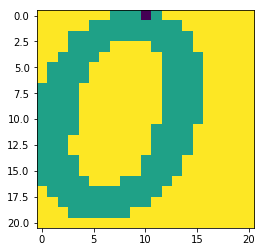

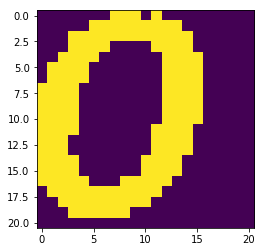

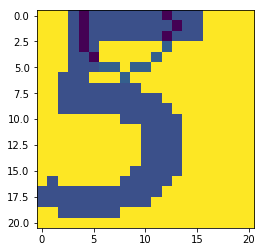

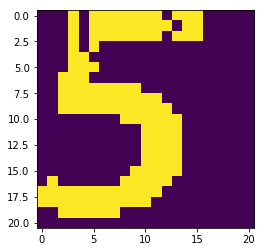

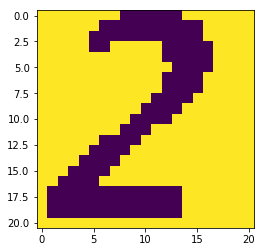

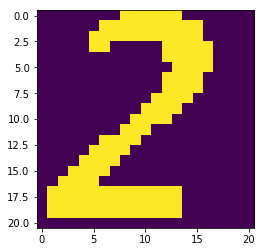

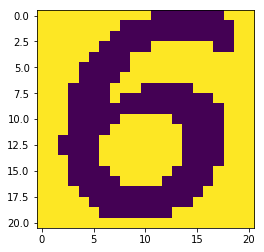

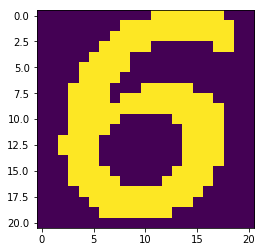

GIF_PNG/4.gif.png GIF_SPLIT/4.gif.png


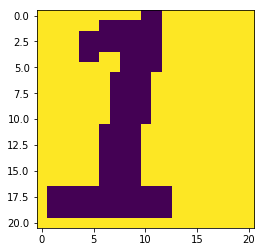

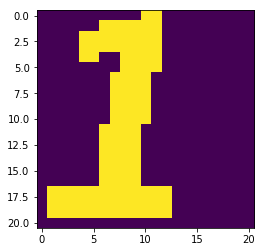

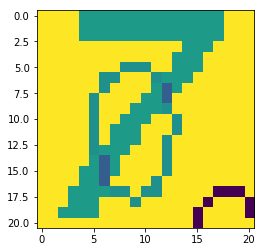

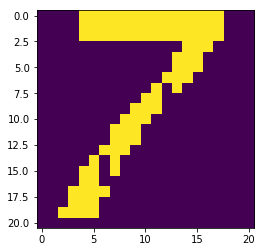

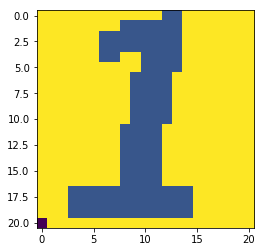

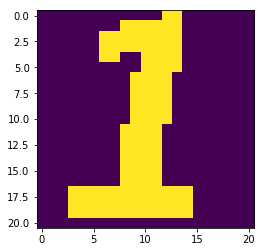

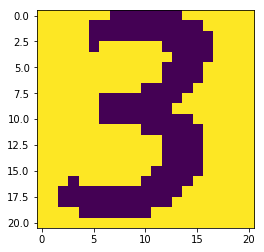

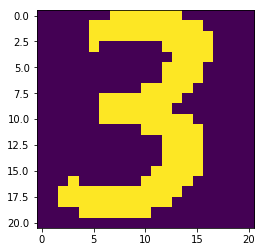

GIF_PNG/6.gif.png GIF_SPLIT/6.gif.png


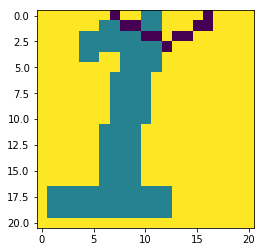

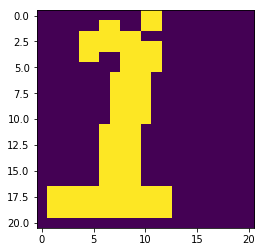

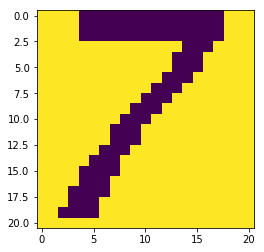

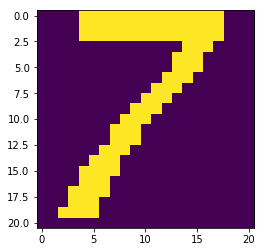

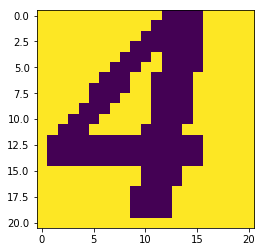

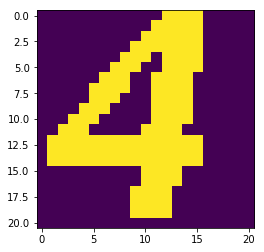

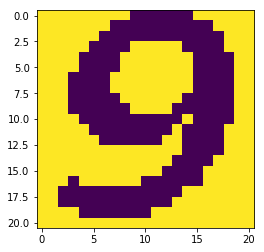

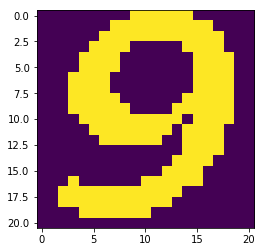

GIF_PNG/7.gif.png GIF_SPLIT/7.gif.png


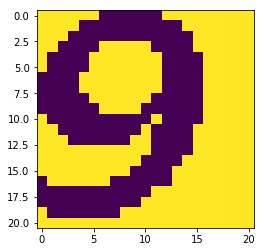

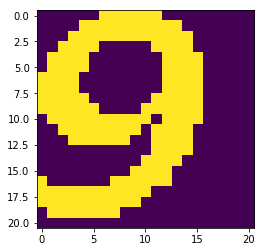

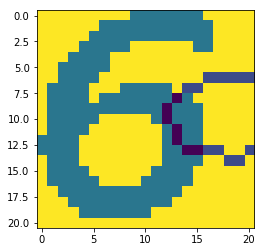

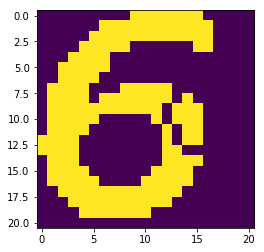

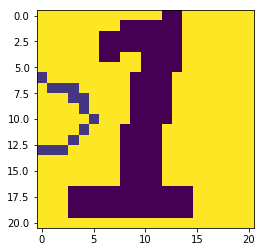

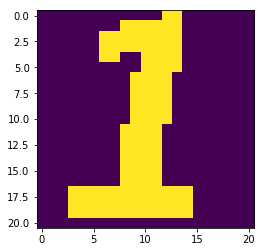

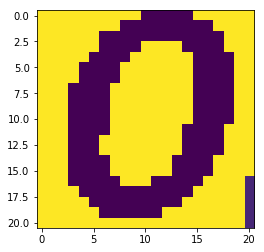

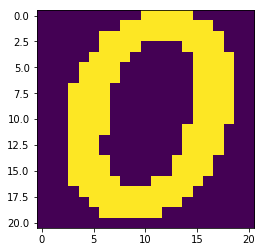

GIF_PNG/2.gif.png GIF_SPLIT/2.gif.png


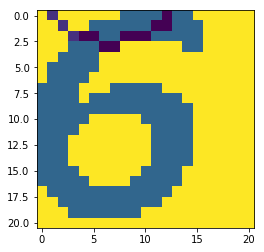

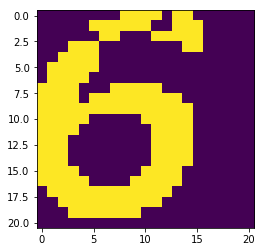

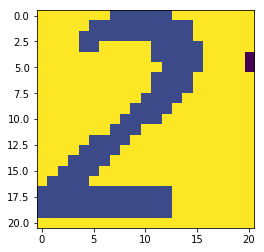

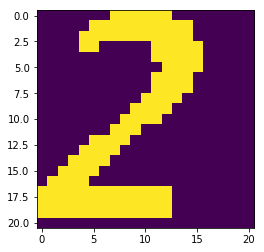

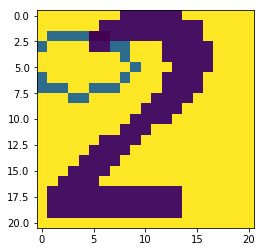

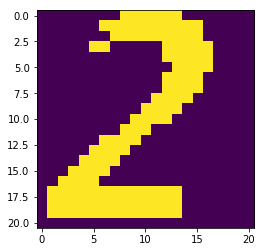

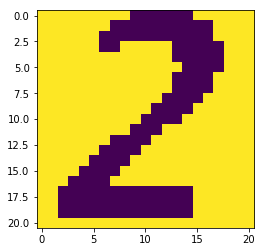

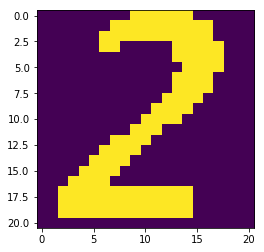

GIF_PNG/10.gif.png GIF_SPLIT/10.gif.png


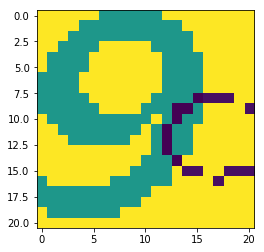

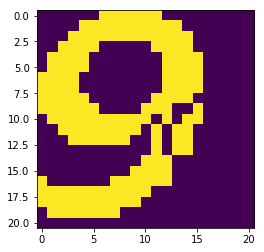

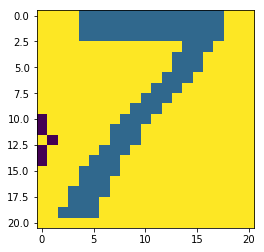

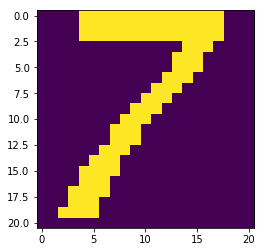

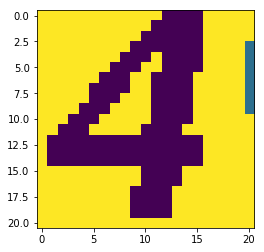

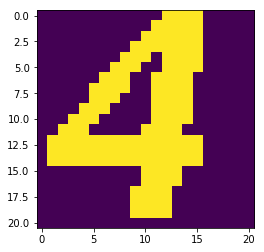

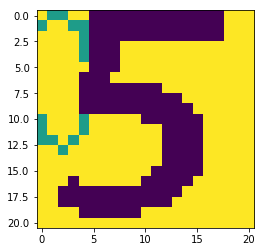

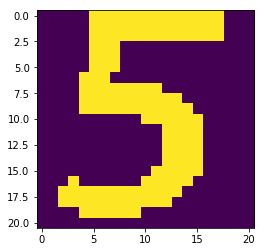

GIF_PNG/3.gif.png GIF_SPLIT/3.gif.png


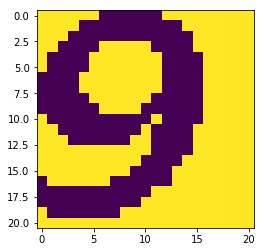

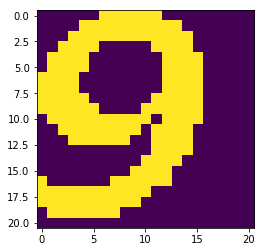

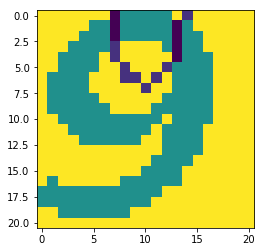

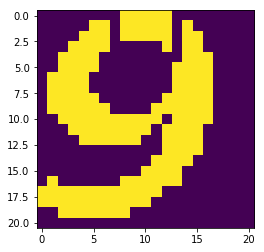

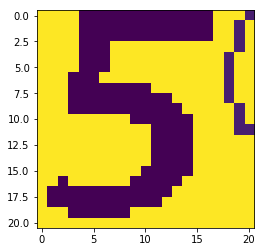

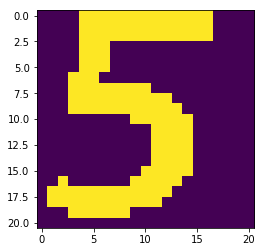

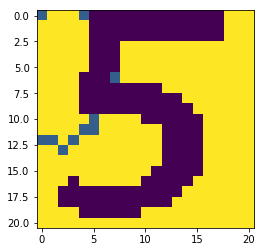

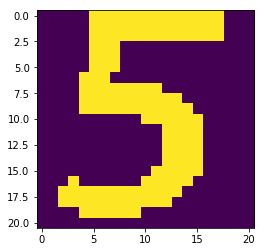

GIF_PNG/8.gif.png GIF_SPLIT/8.gif.png


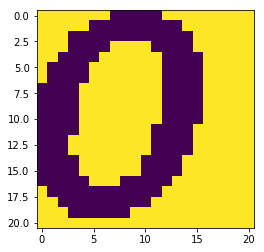

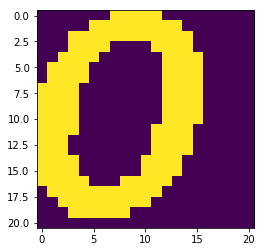

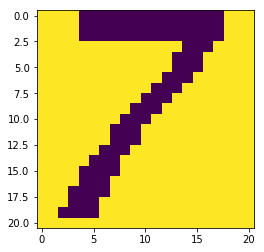

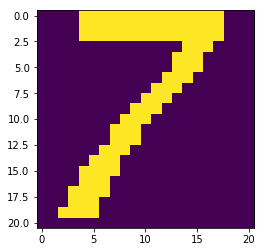

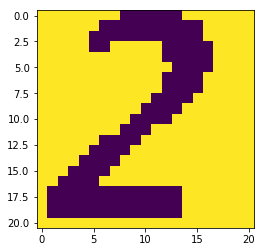

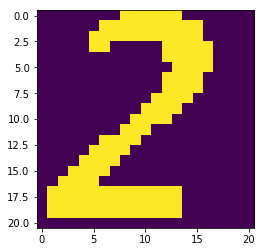

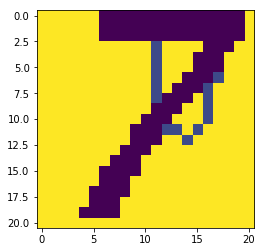

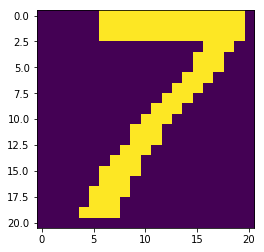

GIF_PNG/1.gif.png GIF_SPLIT/1.gif.png


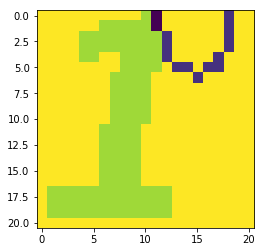

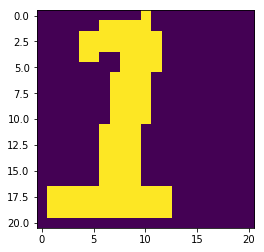

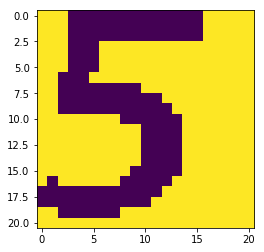

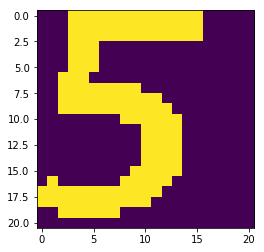

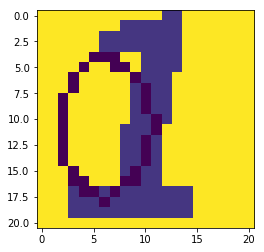

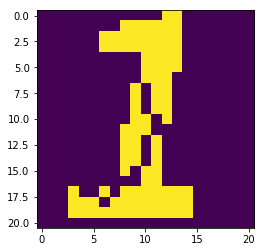

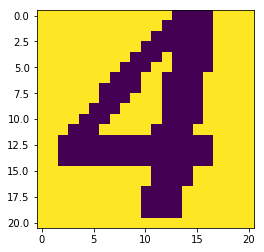

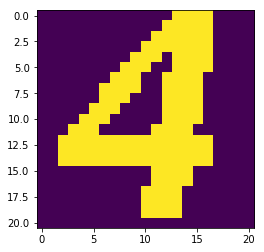

GIF_PNG/9.gif.png GIF_SPLIT/9.gif.png


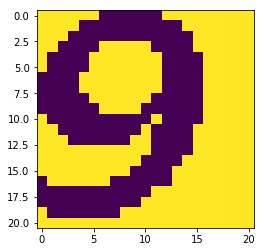

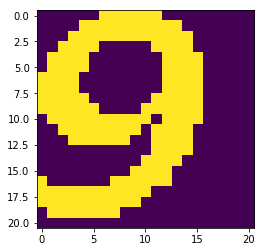

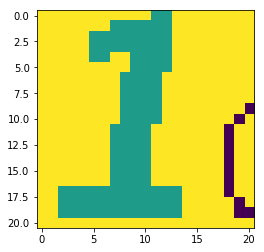

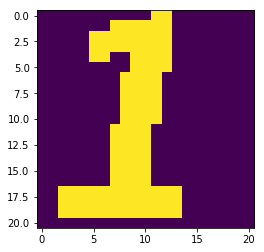

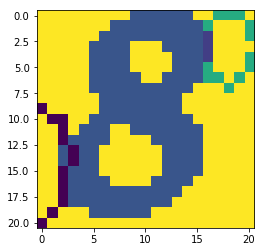

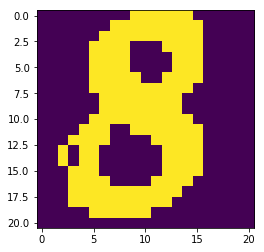

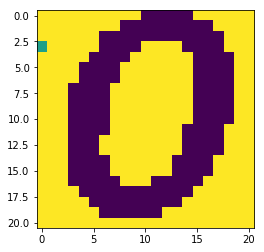

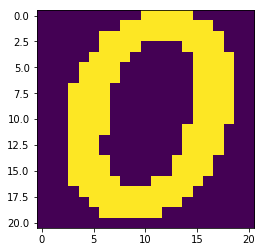

In [4]:
def GIF_TRAIN():
    files= os.listdir("GIF_PNG")
    files.remove(".DS_Store") #mac下的文件夹配置文件。
    for path in files:
        PATH = "GIF_PNG/"+str(path)
        SAVEPATH = "GIF_SPLIT/"+str(path)
        print(PATH,SAVEPATH)
        GIF_SPLIT(PATH,SAVEPATH)
## 开始训练，将所有数字切分并保存在GIF_SPLIT中
GIF_TRAIN()

# 读取测试集图片、开始测试

In [3]:
def KNN_GIF(testpath,gifpath):
    # 读取测试GIF
    img = Image.open(testpath)
    select = 0
    for frame in ImageSequence.Iterator(img):
        select+=1
        if(select==2):
            test_png = frame
            break
    # 打印需要的识别gif
    plt.imshow(test_png)
    plt.show()
    
    # 读取所有GIF_SPLIT
    files = os.listdir(gifpath)
    files.remove(".DS_Store")
    images=np.empty((len(files), 441))

    for i in range(len(files)):
        file_content = (gifpath+files[i])
        file_open = Image.open(file_content)
        images[i] = np.array(file_open).flatten()

    # 每一张图片去切割和匹配
    for i in range(4):
        ## 切隔成4张数字
        left = 21*i
        low = 19
        right = 21*(i+1)
        up = 40
        split = (left,low,right,up)
        img_save = test_png.crop(split)
        img_array = np.array(img_save)
        result = Counter({})
        noise = []
        for j in img_array:
            result+=Counter(j)
        result = dict(result)
        s = sorted(result.values(),reverse = True)
        img_array[img_array==s[0]]=0
        for k,v in result.items():
            if(v != s[0] and v != s[1]):
                noise.append(k)
            if(v==s[0]): #出现最多的一般是背景像素
                zero = k
            if(v==s[1]): #出现第二多的是数字笔画的像素
                val = k
        for n in noise:
            img_array[img_array == n] = 0 # 噪声全部置0
        
        img_array[img_array == zero] = 0
        img_array[img_array == val] = 255

    # KNN算法计算最相似的图片

        dataSetSize = images.shape[0]
        # print(dataSetSize)

        distance1 = np.tile(img_array.flatten(), (dataSetSize)).reshape((dataSetSize,441))-images
        im = img_array.reshape((21,21))
        plt.imshow(Image.fromarray(im))
        plt.show()
        
        distance2 = distance1**2
        distance3 = distance2.sum(axis=1) # 合并成一行
        distances4 = distance3**0.5
        ## 返回从小到大排序的索引
        sortedDistIndicies = distances4.argsort()
        #print(sortedDistIndicies)

        fig=plt.figure(figsize=(8,8))
        fig.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0.05,wspace=0.05)
        for i in range(3):
            im = images[sortedDistIndicies[i]].reshape((21,21))
            ax=fig.add_subplot(6,5,i+1,xticks=[],yticks=[])
            ax.imshow(im,cmap=plt.cm.binary,interpolation='nearest')
        plt.show()

# 运行

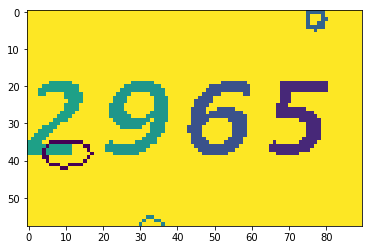

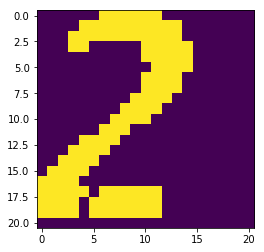

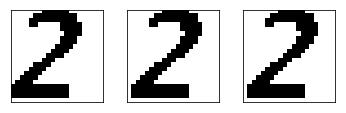

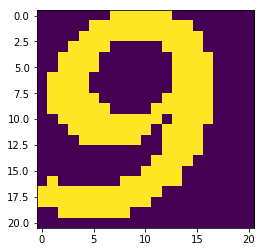

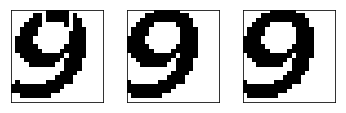

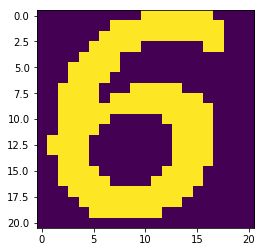

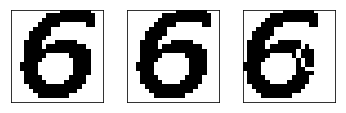

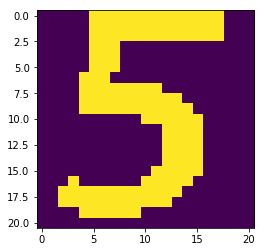

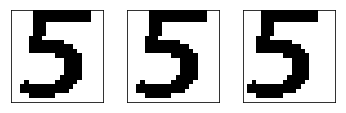

In [4]:
# 测试图片地址
testpath = "GIF_TEST/test-2.gif"
# 训练集目录
gifpath = "GIF_SPLIT/"
# 运行
KNN_GIF(testpath,gifpath)